<a href="https://colab.research.google.com/github/iliakabanov/Adherence-to-the-Taylor-Rule-and-Monetary-Policy-Expectations/blob/main/works_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Устанавливаем окружение

In [ ]:
# !pip cache purge
# !pip uninstall -y numpy scipy rectools
# !pip install "numpy<1.29.0" "scipy<1.11.0" rectools
# !pip install lightning_fabric
# !pip install rectools
# !pip install rectools[torch]
# !pip install gensim
# !pip install -U sentence-transformers

# Имортируем библиотеки и запускаем spark-сессию

In [ ]:
# Get access to Google disk
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Standard library imports
import os
import re
import pickle
import warnings
import textwrap
from pathlib import Path
from collections import Counter
from itertools import chain
from typing import (List, Dict, Optional, Tuple, Union, Any,
                   TypeVar, Callable, Iterable)
from urllib.request import urlopen
from io import BytesIO

# Third-party general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm import tqdm
import threadpoolctl

# Machine learning and data processing
from sklearn.preprocessing import (StandardScaler, MultiLabelBinarizer,
                                 normalize)
from sklearn.cluster import (DBSCAN, AgglomerativeClustering)
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean
from scipy import sparse
from scipy.sparse import hstack, csr_matrix

# Deep learning and NLP
import torch
from sentence_transformers import SentenceTransformer
import timm

# Image processing
from PIL import Image
import requests

# Spark
import pyspark
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_timestamp

# Jupyter specific
from IPython.display import display, Markdown

# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# Import libraries
from lightning_fabric import seed_everything
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback

from rectools import Columns, ExternalIds
from rectools.dataset import Dataset
from rectools.metrics import NDCG, Recall, Serendipity, calc_metrics
from rectools.models import BERT4RecModel, SASRecModel, load_model, PopularInCategoryModel
from implicit.cpu.bpr import BayesianPersonalizedRanking
from rectools.models.implicit_bpr import ImplicitBPRWrapperModel
from rectools.models.nn.item_net import IdEmbeddingsItemNet
from rectools.models.nn.transformers.base import TransformerModelBase

from rectools import Columns
from rectools.dataset import Dataset
from rectools.metrics import (
    MAP,
    CoveredUsers,
    AvgRecPopularity,
    Intersection,
    HitRate,
    Serendipity,
)
from rectools.models import PopularModel, EASEModel, SASRecModel, BERT4RecModel
from rectools.model_selection import TimeRangeSplitter, cross_validate
from rectools.models.nn.item_net import CatFeaturesItemNet, IdEmbeddingsItemNet
from rectools.visuals import MetricsApp

warnings.simplefilter("ignore")

# Enable deterministic behaviour with CUDA >= 10.2
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Random seed
RANDOM_STATE=60
torch.use_deterministic_algorithms(True)
seed_everything(RANDOM_STATE, workers=True)

INFO:lightning_fabric.utilities.seed:Seed set to 60


60

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks/diploma/scripts/"
import process_data

/content/drive/MyDrive/Colab Notebooks/diploma/scripts


In [ ]:
# Создаём SparkSession
spark = SparkSession.builder \
    .appName("PetCo_1") \
    .getOrCreate()

In [ ]:
HEAD_DIRECTORY = '/content/drive/MyDrive/Colab Notebooks/diploma/'

# Фукнции

In [ ]:
def generate_item_text_descriptions(
    catalog: pd.DataFrame,
    text_features: List[str]
) -> pd.DataFrame:
    """Конкатенирует выбранные текстовые признаки товаров через пробел.

    Args:
        catalog: Исходный DataFrame с товарами.
        text_features: Колонки для объединения (в порядке конкатенации).

    Returns:
        DataFrame с одной колонкой 'Text description'.
    """
    text_descriptions = catalog[[text_features[0]]].copy()
    text_descriptions.columns = ['Text description']

    for feature in text_features[1:]:
        text_descriptions['Text description'] += ' ' + catalog[feature].astype(str)

    return text_descriptions

In [ ]:
def generate_item_text_embeddings(catalog: pd.DataFrame, text_features: List[str], model: SentenceTransformer, file_to_save: str, save_frequency: int = 1000) -> np.ndarray:
    """Генерирует текстовые эмбеддинги товаров усреднением векторов описаний.

    Args:
        catalog: DataFrame с товарами и их текстовыми признаками
        text_features: Список колонок для формирования описаний
        model: Модель для генерации эмбеддингов
        file_to_save: Путь для промежуточного сохранения результатов
        save_frequency: Частота автосохранения (в количестве товаров)

    Returns:
        Массив эмбеддингов shape=(n_items, embedding_dim)
    """
    item_descriptions = generate_item_text_descriptions(catalog, text_features)
    embeddings = []

    for i in tqdm(range(len(item_descriptions))):
        desc = item_descriptions.iloc[i, 0]
        embeddings.append(model.encode(desc))

        if (i + 1) % save_frequency == 0:
            with open(file_to_save, "wb") as f:
                pickle.dump(np.array(embeddings), f)

    return np.array(embeddings)

In [ ]:
def sparse_onehot_from_lists(
    df: pd.DataFrame,
    categorical_columns: List[str]
) -> csr_matrix:
    """Преобразует категориальные столбцы со списками значений в sparse one-hot матрицу.

    Обрабатывает:
    - None/NaN → преобразует в пустые списки
    - Списки значений → one-hot кодирование

    Args:
        df: DataFrame с исходными данными
        categorical_columns: Столбцы для обработки (содержат списки значений)

    Returns:
        Объединённая sparse one-hot матрица в CSR формате
    """
    sparse_matrices = []

    for col in categorical_columns:
        # Обработка пропусков и несписочных значений
        cleaned = df[col].apply(lambda x: x if isinstance(x, list) else [])

        # Sparse one-hot кодирование
        mlb = MultiLabelBinarizer(sparse_output=True)
        sparse_matrices.append(mlb.fit_transform(cleaned))

    return hstack(sparse_matrices, format='csr')

In [ ]:
def generate_item_image_embeddings(
    catalog: pd.DataFrame,
    feature: str,
    image_model: timm.models.mobilenetv3.MobileNetV3,
    file_to_save: str
) -> np.ndarray:
    """
    Генерирует эмбеддинги изображений товаров.

    :param catalog: Датасет с товарами. Должен содержать столбец с URL изображений.
    :param feature: Название столбца с URL изображений.
    :param image_model: Предобученная модель для генерации эмбеддингов.
    :param file_to_save: Путь для сохранения промежуточных результатов.
    :return: Массив эмбеддингов изображений shape=(n_items, embedding_dim)
    """
    item_image_embeddings = []
    working_urls = 0

    for i in tqdm(range(len(catalog))):
        image_url = catalog[feature].iloc[i]

        if check_image_url(image_url):
            response = requests.get(image_url, stream=True, timeout=5)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))
            if img.mode != 'RGB':
                img = img.convert('RGB')

            output = image_model.forward_features(transforms(img).unsqueeze(0))
            embedding = image_model.forward_head(output, pre_logits=True).detach().numpy()[0, :]
            working_urls += 1
        else:
            embedding = np.zeros(1024)

        item_image_embeddings.append(embedding)

        if i % 1000 == 0:
            with open(file_to_save, "wb") as f:
                pickle.dump(np.array(item_image_embeddings), f)

    return np.array(item_image_embeddings)

In [ ]:
def create_user_histories(interactions_df: pd.DataFrame) -> Dict[int, List[int]]:
    """
    Создает словарь историй пользователей на основе взаимодействий с товарами.

    :param interactions_df: Датасет с взаимодействиями пользователей с товарами.
                            Должен содержать столбцы: 'user_id', 'item_id'.
    :return: Словарь {user_id: список товаров, с которыми взаимодействовал пользователь}
    """
    user_histories = {}

    # Группируем данные по user_id и собираем список item_id для каждого пользователя
    for user_id, group in tqdm(interactions_df.groupby('user_id')):
        user_histories[user_id] = group['item_id'].tolist()

    return user_histories

In [ ]:
def aggregate_user_cat_embeddings(
    users_histories: Dict[int, List[int]],
    sparse_cat_features: sparse.csr_matrix,
    itemid2index: Dict[int, int]
) -> Tuple[np.ndarray, Dict[int, int]]:
    """
    Агрегирует категориальные признаки товаров в эмбеддинги пользователей.

    :param users_histories: Словарь {user_id: список item_id} с историями просмотров
    :param sparse_cat_features: Sparse-матрица one-hot признаков товаров
    :param itemid2index: Соответствие item_id индексам в sparse_cat_features
    :return: Кортеж (матрица эмбеддингов пользователей, словарь user_id -> индекс)
    """
    num_users = len(users_histories)
    num_features = sparse_cat_features.shape[1]
    user_embeddings = sparse.lil_matrix((num_users, num_features), dtype=np.float32)
    userid2index = {}

    i = 0
    for user_id, item_ids in tqdm(users_histories.items()):
        userid2index[user_id] = i
        indeces = [itemid2index[item_id] for item_id in item_ids if item_id in itemid2index.keys()]
        user_item_features = sparse_cat_features[indeces, :]

        sum_features = user_item_features.sum(axis=0)
        user_embeddings[i] = sum_features
        i += 1

    return user_embeddings.toarray(), userid2index

In [ ]:
def aggregate_user_noncat_embeddings(
    user_histories: Dict[int, List[int]],
    item_embeddings: np.ndarray,
    itemid2index: Dict[int, int]
) -> Tuple[np.ndarray, int]:
    """
    Генерирует эмбеддинги пользователей усреднением эмбеддингов товаров из их истории.

    :param user_histories: {user_id: список item_id} - истории взаимодействий
    :param item_embeddings: Массив эмбеддингов товаров shape=(n_items, embedding_dim)
    :param itemid2index: {item_id: индекс} в item_embeddings
    :return: Кортеж (массив эмбеддингов пользователей, количество пропущенных товаров)
    """
    user_embeddings = []
    missed_items = 0

    for user_id, item_ids in tqdm(user_histories.items()):
        item_vectors = []

        for item_id in item_ids:
            if item_id in itemid2index:
                item_vectors.append(item_embeddings[itemid2index[item_id]])
            else:
                missed_items += 1

        if item_vectors:
            user_embeddings.append(np.mean(item_vectors, axis=0))
        else:
            user_embeddings.append(np.zeros(item_embeddings.shape[1]))

    return np.array(user_embeddings), missed_items

In [ ]:
def generate_user_embeddings(
    actions: pd.DataFrame,
    catalog: pd.DataFrame,
    text_features: List[str],
    cat_features: List[str],
    image_column: str,
    text_model: object,
    image_model: object
) -> np.ndarray:
    """
    Генерирует объединенные эмбеддинги пользователей на основе их взаимодействий с товарами.
    Комбинирует текстовые, категориальные и визуальные эмбеддинги товаров.

    :param actions: DataFrame с историей взаимодействий пользователей
    :param catalog: DataFrame с каталогом товаров и их признаками
    :param text_features: Список текстовых признаков для генерации эмбеддингов
    :param cat_features: Список категориальных признаков для one-hot кодирования
    :param image_column: Название столбца с URL изображений
    :param text_model: Модель для генерации текстовых эмбеддингов
    :param image_model: Модель для генерации визуальных эмбеддингов
    :return: np.ndarray (объединенные эмбеддинги пользователей)
    """
    # Загрузка предварительно сохраненных эмбеддингов
    item_text_embeddings = pd.read_pickle(HEAD_DIRECTORY+'embeddings/items_names.pkl')
    sparse_item_cat_embeddings = sparse_onehot_from_lists(df=catalog, categorical_columns=cat_features)
    item_image_embeddings = pd.read_pickle(HEAD_DIRECTORY+'embeddings/items_images.pkl')

    # Проверка согласованности данных
    assert item_text_embeddings.shape[0] == sparse_item_cat_embeddings.shape[0] == item_image_embeddings.shape[0]

    # Создание истории пользователей и mapping'ов
    user_histories = create_user_histories(actions)
    itemid2index = {catalog['item_id'].iloc[i]: i for i in range(len(catalog['item_id']))}

    # Генерация отдельных эмбеддингов
    user_text_embeddings, _ = aggregate_user_noncat_embeddings(user_histories, item_text_embeddings, itemid2index)
    user_cat_embeddings, userid2index = aggregate_user_cat_embeddings(user_histories, sparse_item_cat_embeddings, itemid2index)
    user_image_embeddings, _ = aggregate_user_noncat_embeddings(user_histories, item_image_embeddings, itemid2index)

    # Объединение всех эмбеддингов
    user_embeddings = np.hstack((user_text_embeddings, user_cat_embeddings, user_image_embeddings))

    return user_embeddings, userid2index

In [ ]:
def tsne(
    vectors: Union[np.ndarray, List[List[float]]],
    perplexity: int = 30,
    random_state: int = 42
) -> np.ndarray:
    """
    Применяет t-SNE для уменьшения размерности векторов до 2D.

    Параметры:
        vectors: Входные векторы (n_samples, n_features)
        perplexity: Параметр perplexity для t-SNE (по умолчанию 30)
        random_state: Seed для воспроизводимости (по умолчанию 42)

    Возвращает:
        Массив формы (n_samples, 2) с проекциями в 2D пространстве
    """
    # Стандартизация данных
    scaler = StandardScaler()
    scaled_vectors = scaler.fit_transform(vectors)

    # Применение t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    return tsne.fit_transform(scaled_vectors)

def visualize_tsne(
    projected_vectors: np.ndarray,
    title: str = 't-SNE visualization',
    figsize: tuple = (10, 8),
    point_size: int = 50
) -> None:
    """
    Визуализирует 2D проекции векторов.

    Параметры:
        projected_vectors: Массив проекций формы (n_samples, 2)
        title: Заголовок графика (по умолчанию 't-SNE visualization')
        figsize: Размер фигуры (по умолчанию (10, 8))
        point_size: Размер точек на графике (по умолчанию 50)
    """
    plt.figure(figsize=figsize)
    sns.scatterplot(
        x=projected_vectors[:, 0],
        y=projected_vectors[:, 1],
        s=point_size
    )

    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def dbscan_clustering(data, eps=0.5, min_samples=5, tsne_for_high_dim=True):
    """
    Выполняет кластеризацию DBSCAN и визуализирует результаты.

    Параметры:
    - data: numpy array (n_samples, n_features)
    - eps: максимальное расстояние между соседями для DBSCAN
    - min_samples: минимальное количество соседей для core точки
    - visualize: если True, строит график кластеров

    Возвращает:
    - labels: метки кластеров (-1 - выбросы)
    """
    # Стандартизация данных
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    # Кластеризация DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(scaled_data)

    return scaled_data, labels


def visualise_dbscan(scaled_data, labels, eps, min_samples):

    userid2cluster = {}
    for user_id, index in userid2index.items():
      userid2cluster[user_id] = labels[index]

    plt.figure(figsize=(10, 8))

    vis_data = scaled_data[:, :2]
    x_label, y_label = 't-SNE dimension 1', 't-SNE dimension 2'

    # Визуализация
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'gray'  # Выбросы серым

        class_member_mask = (labels == k)
        xy = vis_data[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=50, label=f'Cluster {k}' if k != -1 else 'Outliers')

    plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

    return userid2cluster

In [ ]:
def show_image_from_url(url):
    """
    Проверяет существование изображения по URL и выводит его на экран.

    Параметры:
        url (str): Ссылка на изображение в интернете.

    Возвращает:
        bool: True если изображение существует и отображено, иначе False.
    """
    try:
        # Загружаем изображение с проверкой HTTP-статуса
        response = requests.get(url, stream=True, timeout=5)
        response.raise_for_status()  # Проверяет на ошибки HTTP (404, 403 и т.д.)

        # Проверяем, что это действительно изображение
        if 'image' not in response.headers['Content-Type']:
            print("⚠️ URL не ведет к изображению (Content-Type:", response.headers['Content-Type'], ")")
            return False

        # Преобразуем байты в изображение и выводим
        img = Image.open(BytesIO(response.content))

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')  # Скрываем оси
        plt.title(f"Изображение из URL:\n{url[:50]}...", fontsize=10)
        plt.show()
        return img

    except requests.exceptions.RequestException as e:
        print(f"❌ Ошибка при загрузке изображения: {e}")
        return False
    except Exception as e:
        print(f"⚠️ Неожиданная ошибка: {e}")
        return False

In [ ]:
def check_image_url(url):
    """Проверяет, доступно ли изображение по URL."""
    try:
        response = requests.head(url, timeout=5, allow_redirects=True)
        if response.status_code == 200 and 'image' in response.headers.get('Content-Type', ''):
            return True
        return False
    except:
        return False

In [ ]:
def get_user_histories_by_cluster(
    cluster: int,
    clusters: Dict[int, int],
    interactions_with_features: pd.DataFrame,
    n_examples: int = 3
) -> None:
    """
    Выводит примеры пользовательских историй для заданного кластера.

    Параметры:
        cluster: Номер кластера для отображения примеров
        clusters: Словарь {user_id: cluster_label} с принадлежностью к кластерам
        interactions_with_features: DataFrame с историей взаимодействий пользователей
        n_examples: Количество примеров для отображения (по умолчанию 3)

    Возвращает:
        None (функция только выводит информацию на экран)
    """
    n_printed_examples = 0

    for user_id, user_cluster in clusters.items():
        if user_cluster == cluster:
            display_user_actions(
                user_id=user_id,
                df=interactions_with_features,
                n_cols=10,
                show_text=True
            )
            n_printed_examples += 1

            if n_printed_examples >= n_examples:
                break

In [ ]:
def display_user_actions(
    user_id: int,
    df: pd.DataFrame,
    n_cols: int = 5,
    cell_width: float = 2.5,
    cell_height: float = 3,
    show_text: bool = True,
    fontsize: int = 8,
    max_name_length: int = 20,
    timeout: float = 3.0,
    image_url_column: str = 'image_url',
    item_id_column: str = 'item_id',
    name_column: str = 'name'
) -> None:
    """
    Визуализирует действия пользователя с фиксированным размером ячеек.

    Параметры:
        user_id: ID пользователя для отображения
        df: DataFrame с данными о взаимодействиях
        n_cols: Количество колонок в сетке (по умолчанию 5)
        cell_width: Ширина ячейки в дюймах (по умолчанию 2.5)
        cell_height: Высота ячейки в дюймах (по умолчанию 3)
        show_text: Показывать текстовую информацию (по умолчанию True)
        fontsize: Размер шрифта (по умолчанию 8)
        max_name_length: Максимальная длина строки названия (по умолчанию 20)
        timeout: Таймаут загрузки изображения в секундах (по умолчанию 3.0)
        image_url_column: Название колонки с URL изображений (по умолчанию 'image_url')
        item_id_column: Название колонки с ID товаров (по умолчанию 'item_id')
        name_column: Название колонки с именами товаров (по умолчанию 'name')
    """
    user_items = df[df['user_id'] == user_id]
    if user_items.empty:
        print(f"Пользователь {user_id} не найден.")
        return

    n_items = len(user_items)
    n_rows = int(np.ceil(n_items / n_cols))
    figsize = (n_cols * cell_width, n_rows * cell_height)
    fig = plt.figure(figsize=figsize)
    grid = plt.GridSpec(n_rows, n_cols, wspace=0.1, hspace=0.2)

    for idx, (_, row) in enumerate(user_items.iterrows()):
        ax = fig.add_subplot(grid[idx // n_cols, idx % n_cols])

        try:
            # Загрузка и обработка изображения
            response = requests.get(row[image_url_column], timeout=timeout)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content))

            # Масштабирование с сохранением пропорций
            img_aspect = img.size[0] / img.size[1]
            display_width = min(cell_width * 0.9, cell_height * 0.8 * img_aspect)
            display_height = display_width / img_aspect

            ax.imshow(img, extent=[
                (cell_width - display_width)/2,
                (cell_width + display_width)/2,
                (cell_height - display_height)/2,
                (cell_height + display_height)/2
            ])

            if show_text:
                name = '\n'.join(textwrap.wrap(row[name_column], max_name_length))
                ax.text(
                    cell_width/2, -0.2*cell_height,
                    f"ID: {row[item_id_column]}\n{name}",
                    ha='center', va='top',
                    fontsize=fontsize, wrap=True
                )

        except Exception as e:
            # Обработка ошибок загрузки изображения
            ax.add_patch(plt.Rectangle(
                (0, 0), cell_width, cell_height,
                color='lightgray'
            ))
            if show_text:
                ax.text(
                    cell_width/2, cell_height/2, 'X',
                    color='red', ha='center', va='center'
                )
                ax.text(
                    cell_width/2, -0.2*cell_height,
                    f"ID: {row[item_id_column]}",
                    ha='center', va='top', fontsize=fontsize
                )

        ax.set_xlim(0, cell_width)
        ax.set_ylim(-0.3*cell_height if show_text else 0, cell_height)
        ax.axis('off')

    # Скрытие пустых ячеек
    for idx in range(n_items, n_rows * n_cols):
        fig.add_subplot(grid[idx // n_cols, idx % n_cols]).axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
class PopularInUserModel():
    def __init__(self, k: int = 10):
        """
        Рекомендательная система на основе популярности.
        :param top_n: Количество рекомендаций на пользователя
        """
        self.top_n = k
        self.item_popularity = None
        self.user_top_items = None

    def fit(self, interactions: pd.DataFrame):
        """
        Обучает модель на данных о взаимодействиях пользователей с товарами.
        :param interactions: DataFrame с колонками ['user_id', 'item_id']
        """
        # Подсчет популярности товаров
        item_counts = interactions['item_id'].value_counts().reset_index()
        item_counts.columns = ['item_id', 'score']
        self.item_popularity = item_counts

        # Топ-10 популярных товаров для каждого пользователя
        user_top_items = (
            interactions.groupby('user_id')['item_id']
            .value_counts()
            .reset_index(name='score')
        )

        self.user_top_items = user_top_items[user_top_items.groupby('user_id').cumcount() < self.top_n]

    def recommend(self, user_ids: List[int], train_dataset = None, k = None, filter_viewed = None) -> pd.DataFrame:
        """
        Возвращает DataFrame с рекомендациями в формате user_id, item_id, score, rank.
        :param user_ids: Список ID пользователей
        :return: DataFrame с рекомендациями
        """
        if self.user_top_items is None or self.item_popularity is None:
            raise ValueError("Модель не обучена. Вызовите .fit() перед рекомендациями.")

        recommendations = []
        for user_id in user_ids:
            user_items = self.user_top_items[self.user_top_items['user_id'] == user_id].sort_values(by='score', ascending=False)

            # Дополняем недостающие рекомендации самыми популярными товарами
            if len(user_items) < self.top_n:
                additional_items = self.item_popularity[~self.item_popularity['item_id'].isin(user_items['item_id'])]
                additional_items = additional_items.head(self.top_n - len(user_items)).copy().sort_values(by='score', ascending=False)
                additional_items['user_id'] = user_id
                user_items = pd.concat([user_items, additional_items], ignore_index=True)

            user_items = user_items.head(self.top_n)
            user_items['rank'] = range(1, len(user_items) + 1)
            recommendations.append(user_items)

        return pd.concat(recommendations, ignore_index=True)[['user_id', 'item_id', 'score', 'rank']]

In [ ]:
import numpy as np
from collections import Counter

def keep_top_10_clusters(labels):
    """
    Оставляет только 10 самых многочисленных кластеров, остальные помечает как шум (-1).

    Параметры:
    - labels: массив с метками кластеров (например, результат DBSCAN)

    Возвращает:
    - Модифицированный массив меток, где только 10 самых больших кластеров сохранили свои номера,
      а остальным присвоено -1
    """
    # Считаем количество точек в каждом кластере (исключая шум -1)
    cluster_counts = Counter(labels)
    if -1 in cluster_counts:
        del cluster_counts[-1]  # Игнорируем точки шума

    # Если кластеров 10 или меньше - ничего не меняем
    if len(cluster_counts) <= 10:
        return labels.copy()

    # Находим 10 самых больших кластеров
    top_10_clusters = [cluster for cluster, _ in cluster_counts.most_common(10)]

    # Создаем новый массив меток
    new_labels = np.full_like(labels, -1)  # По умолчанию - шум

    # Сохраняем только топ-10 кластеров
    for cluster in top_10_clusters:
        new_labels[labels == cluster] = cluster

    return new_labels

In [ ]:
def get_cluster_examples(userid2clusters: Dict[int, int]):
  cluster_examples = {}
  for cluster in np.unique(list(userid2clusters.values()))[1:]:
    for user_id, user_cluster in userid2clusters.items():
      if user_cluster == cluster:
        cluster_examples[cluster] = user_id
        break

  return cluster_examples

# Данные


In [ ]:
# sasrec_data_folder_path = HEAD_DIRECTORY+'data/sasrec_format/'
# output_name = 'actions'
# data_actions_processed = spark.read.parquet(sasrec_data_folder_path+output_name).orderBy(['user_id', 'datetime'])

In [ ]:
# sasrec_data_folder_path = HEAD_DIRECTORY+'data/sasrec_format/'
# output_name = 'items'
# data_items_processed = spark.read.parquet(sasrec_data_folder_path+output_name).orderBy('id', 'feature', 'value')
# data_items_cleaned = spark.read.parquet(HEAD_DIRECTORY+'data/cleaned_data/data_items')

In [ ]:
# actions, items_features = process_data.processed_datasets_to_pandas(data_actions_processed, data_items_processed)
# actions.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/actions.pkl')
# items_features.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/items.pkl')
actions = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/actions.pkl')
items = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/items.pkl')

In [ ]:
# catalog = data_items_cleaned.select('customer_id', 'name', 'group_ids_intersect', 'How_to_get_it', 'Primary_Brand', 'Primary_Pet_Type', 'image_url').toPandas()
# catalog.rename(columns={'customer_id': 'item_id'}, inplace=True)
# catalog['item_id'] = catalog['item_id'].apply(lambda x: int(x))
# catalog = catalog.rename(columns={'group_ids_intersect': 'Category', 'How_to_get_it': 'Delivery', 'Primary_Brand': 'Brand', 'Primary_Pet_Type': 'Pet'})
# catalog['Pet'] = catalog['Pet'].apply(lambda x: x[0].split(',') if x else x)
# catalog.to_pickle(HEAD_DIRECTORY+'data/sasrec_format/catalog.pkl')
catalog = pd.read_pickle(HEAD_DIRECTORY+'data/sasrec_format/catalog.pkl')
actions_with_item_features = actions.merge(catalog, on='item_id', how='left')

In [ ]:
# В валлидационный датасет откладываем последнее действие для каждого юзера
val_df = actions.loc[actions.groupby("user_id")["datetime"].idxmax()]

# Обучающий датасет – все, кроме последней итерации у каждого пользователя
train_df = actions.drop(val_df.index)
train_df_with_features = train_df.merge(catalog, on='item_id', how='left')

# Кластеризация юзеров по их историям конверсий

In [ ]:
# Загружаем текстовую модель
text_model = SentenceTransformer('nfhakim/topic-clustering-v1')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/118 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/709k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Загружаем модель для создания эмбеддингов картинок
image_model = timm.create_model(
    'mobilenetv3_small_100.lamb_in1k',
    pretrained=True
)
image_model = image_model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(image_model)
transforms = timm.data.create_transform(**data_config, is_training=False)

model.safetensors:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

In [ ]:
# Создаем эмбеддинги юзеров по историям их конверсий
user_embeddings, userid2index = generate_user_embeddings(actions=actions,
                                                         catalog=catalog,
                                                         text_features=['name'],
                                                         cat_features=['Category', 'Delivery', 'Brand', 'Pet'],
                                                         image_column='image_url',
                                                         text_model=text_model,
                                                         image_model=image_model)
user_embeddings.shape

100%|██████████| 19688/19688 [00:02<00:00, 8649.99it/s] 


(19688, 4090)

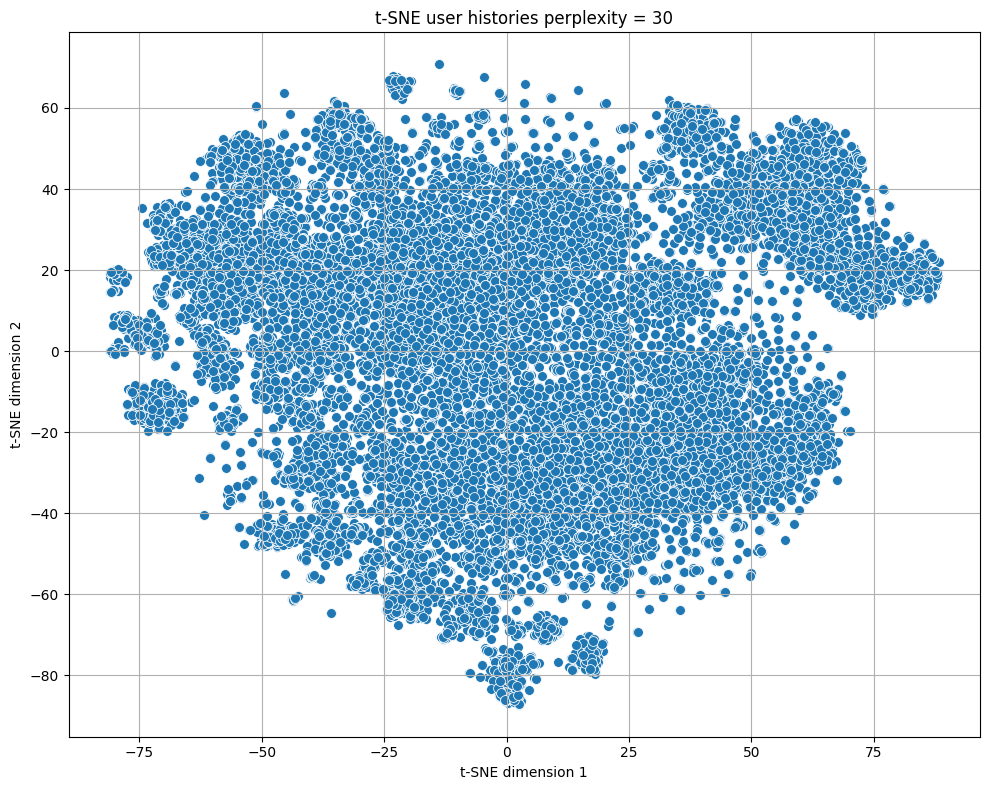

In [ ]:
# Проектируем эмеддинги на плоскость и визуализируем их

# projected_vectors = tsne(user_embeddings, perplexity=30)
# with open(HEAD_DIRECTORY+'embeddings/users_tsne_text_cat_image.pkl', "wb") as f:
#   pickle.dump(projected_vectors, f)
projected_vectors = pd.read_pickle(HEAD_DIRECTORY+'embeddings/users_tsne_2d_text_cat_image.pkl')
visualize_tsne(projected_vectors, title='t-SNE user histories perplexity = 30')

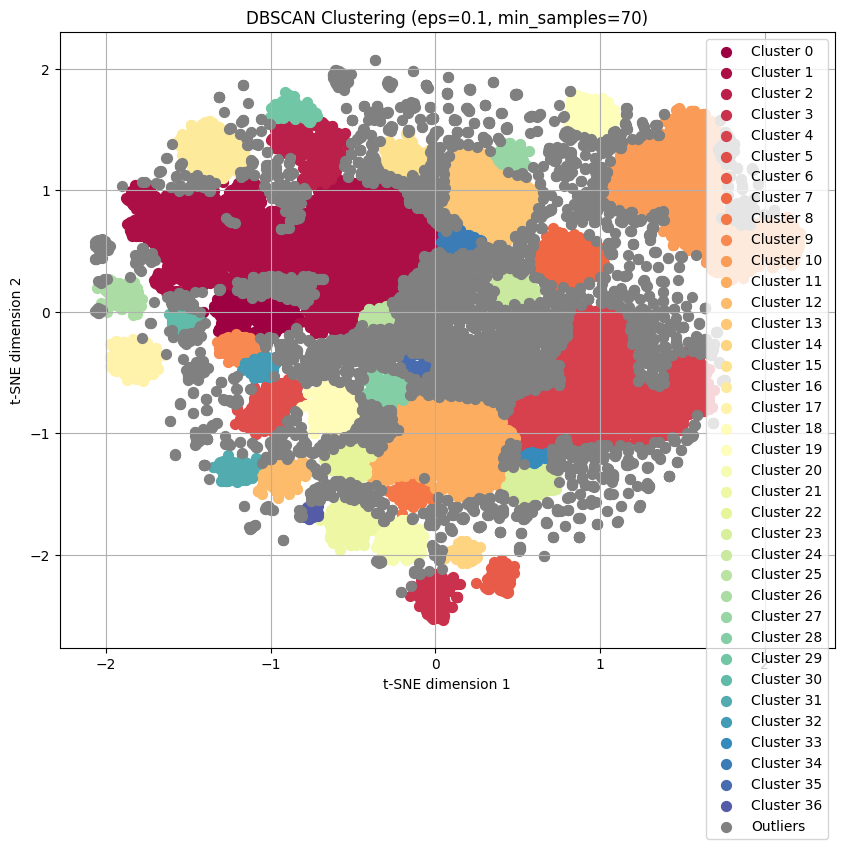

In [ ]:
# Кластеризуем юзеров с помощью DBSCAN
scaled_vectors, labels = dbscan_clustering(projected_vectors, eps=0.1, min_samples=70)
userid2cluster = visualise_dbscan(scaled_vectors, labels, 0.1, 70)

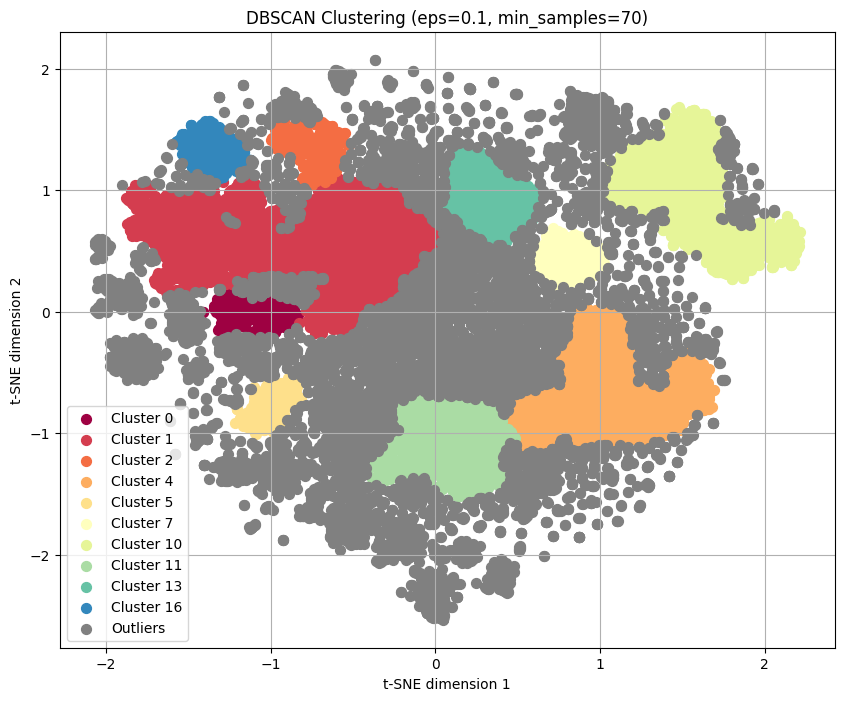

In [ ]:
# Оставляем только 10 самых крупных кластеров
userid2cluster = visualise_dbscan(scaled_vectors, keep_top_10_clusters(labels), 0.1, 70)

In [ ]:
# Смотрим на однородность кластера
get_user_histories_by_cluster(cluster=1, clusters=userid2cluster, interactions_with_features=actions_with_item_features, n_examples=3)

In [ ]:
#Получаем по одному примеру из каждого кластера
cluster_examples = get_cluster_examples(userid2clusters=userid2cluster)
cluster_examples

{0: 146163,
 1: 154695,
 2: 768726,
 4: 2378,
 5: 1056925,
 7: 1485739,
 10: 733322,
 11: 806550,
 13: 237492,
 16: 875393}

# Модели

In [ ]:
# Construct dataset
features_final_names = ['Category', 'Delivery', 'Brand', 'Pet']
train_dataset = Dataset.construct(
    interactions_df=train_df,
    item_features_df=items,
    cat_item_features=features_final_names,
)

val_dataset = Dataset.construct(
    interactions_df=val_df,
    item_features_df=items,
    cat_item_features=features_final_names,
)

In [ ]:
pop_model = PopularModel("n_interactions")
pop_model.fit(train_dataset)

In [ ]:
from rectools.models import PopularInCategoryModel
pop_cat_model = PopularInCategoryModel(category_feature='Pet', popularity='n_interactions')
pop_cat_model.fit(dataset = train_dataset)

In [ ]:
pop_user_model = PopularInUserModel(k=10)
pop_user_model.fit(interactions=train_df)

In [ ]:
from implicit.cpu.bpr import BayesianPersonalizedRanking
from rectools.models.implicit_bpr import ImplicitBPRWrapperModel
bpr_model = BayesianPersonalizedRanking()
bpr_model = ImplicitBPRWrapperModel(model=bpr_model)
bpr_model.fit(dataset=train_dataset)

In [ ]:
# Рекомендации SASRec просто читаем из файла, которые мы уже сделали ранее
sasrec_recos_all = pd.read_pickle(HEAD_DIRECTORY+'results/sasrec_recos.pkl')

# Избранные примеры рекомендаций

In [ ]:
test_users = list(cluster_examples.values())

# Кластер 1

In [ ]:
%%time
test_user = test_users[0]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 118 ms, sys: 70 µs, total: 118 ms
Wall time: 122 ms


**<font size='+2'>user 146163 conversions from cluster 0</font>**

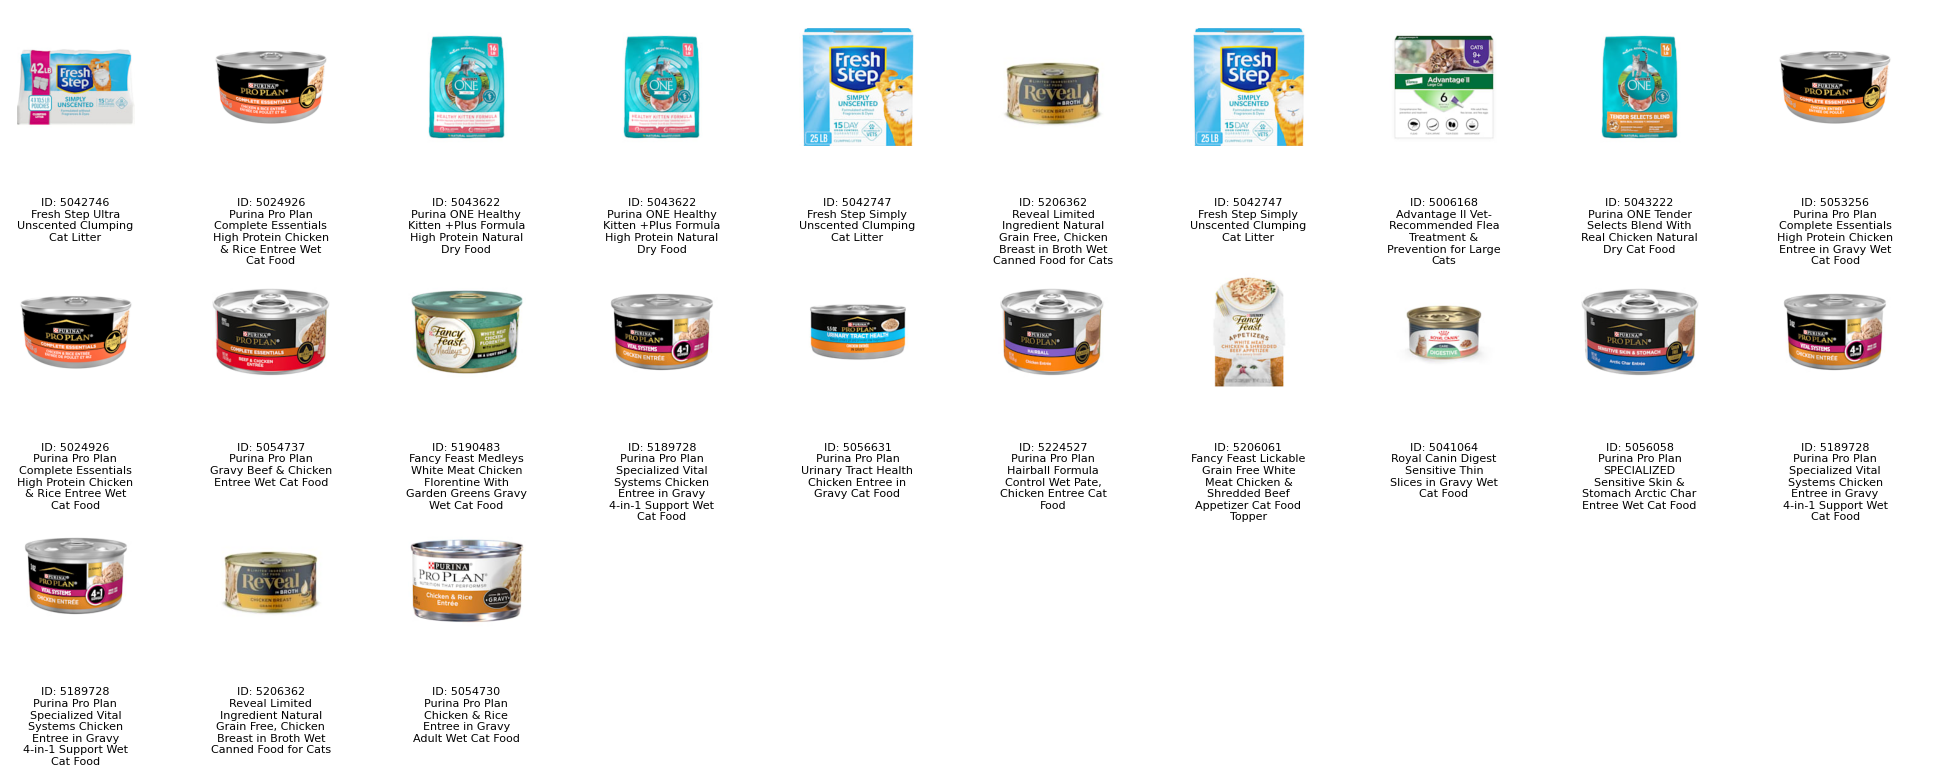

**<font size='+2'>PopModel Recommendations</font>**

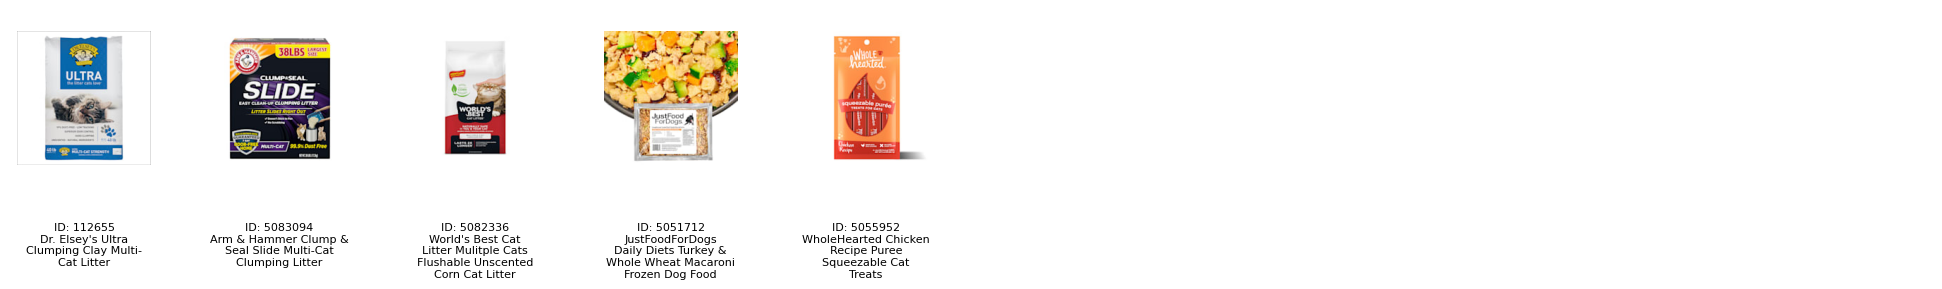

**<font size='+2'>PopUserModel Recommendations</font>**

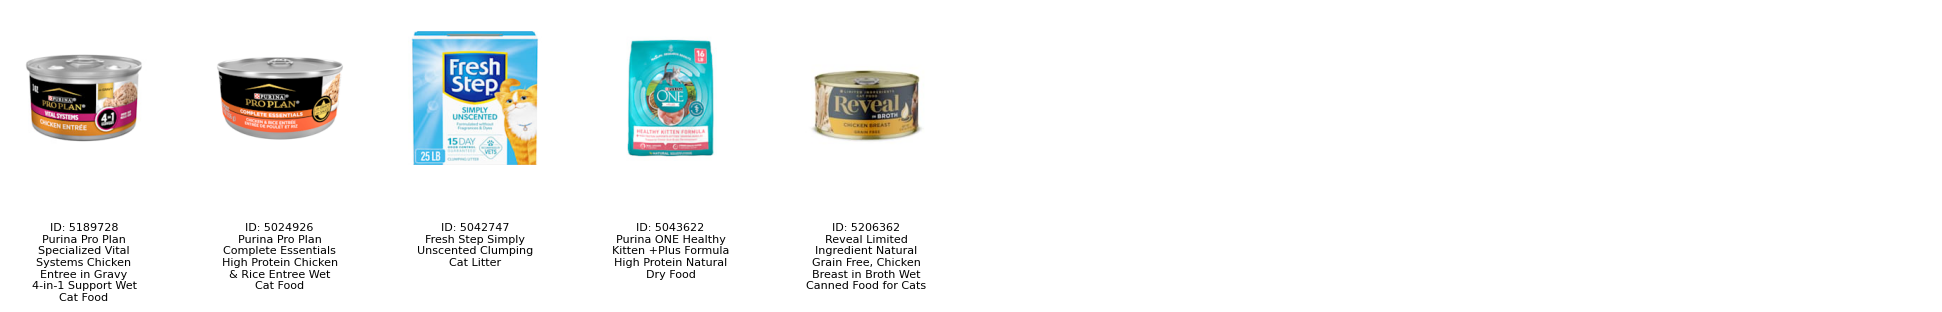

**<font size='+2'>SASRec Recommendations</font>**

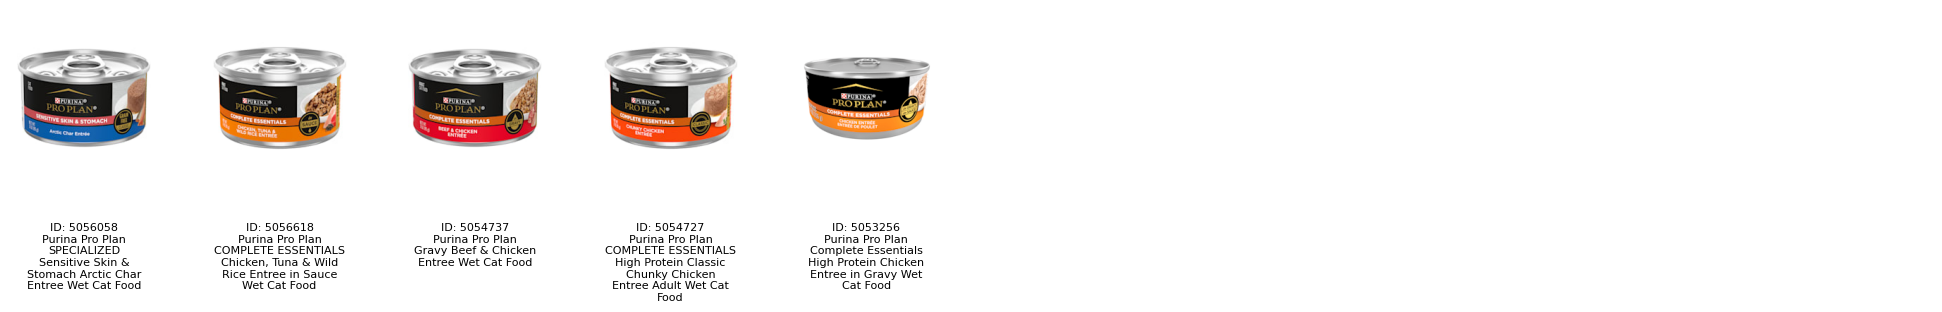

In [ ]:
display(Markdown(f"**<font size='+2'>user {test_user} conversions from cluster {userid2cluster[test_user]}</font>**"))
display_user_actions(user_id=test_user, df = train_df_with_features, n_cols=10, show_text=True)
display(Markdown("**<font size='+2'>PopModel Recommendations</font>**"))
display_user_actions(user_id=test_user, df = pop_recos, n_cols=10, show_text=True)
display(Markdown("**<font size='+2'>PopUserModel Recommendations</font>**"))
display_user_actions(user_id=test_user, df = pop_user_recos, n_cols=10, show_text=True)
display(Markdown("**<font size='+2'>SASRec Recommendations</font>**"))
display_user_actions(user_id=test_user, df = sasrec_recos, n_cols=10, show_text=True)

# Кластер 2

In [ ]:
%%time
test_user = clusters_examples[1]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 76.7 ms, sys: 0 ns, total: 76.7 ms
Wall time: 76 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,48833,5024831,2024-07-03 12:36:51,1,Canidae Pure Real Salmon & Sweet Potato Recipe...,"[dry-dog-food, lid-dog-food-shop, grain-free-d...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
1,48833,5017707,2024-07-03 12:40:34,1,Pup-Peroni Original Beef Flavor Dog Treats,"[jerky-dog-treats, new-brands-low-prices, dog-...","[One Time Delivery, Repeat Delivery]",[Pup-Peroni],[Dog]
2,48833,5024831,2024-07-20 15:24:57,1,Canidae Pure Real Salmon & Sweet Potato Recipe...,"[dry-dog-food, lid-dog-food-shop, grain-free-d...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
3,48833,5199177,2024-07-20 15:27:23,1,Milk-Bone Medium Crunchy Original Dog Biscuits...,"[dog-repeat-delivery-products, new-brands-low-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Milk-Bone],[Dog]
4,48833,5001531,2024-07-20 15:31:36,1,Canidae PURE Grain Free Limited Ingredient Die...,"[grain-free-dog-food, lid-dog-food-shop, dog-r...","[One Time Delivery, Repeat Delivery]",[Canidae],[Dog]
5,48833,5168606,2024-07-20 15:37:12,1,Leaps & Bounds Wildlife Fox Dog Toy,"[dog-plush-toys, same-day-delivery-dog-product...","[Same Day Delivery, Free Pickup Today, One Tim...",[Leaps & Bounds],[Dog]
6,48833,123560,2024-07-20 15:40:56,1,Burt's Bees Oatmeal Dog Shampoo,"[repeat-delivery-eligible-products, buy-online...","[Same Day Delivery, Free Pickup Today, One Tim...",[Burt's Bees],[Dog]
7,48833,5199179,2024-07-31 12:41:44,1,Milk-Bone Small Crunchy Original Dog Biscuits ...,"[buy-online-pick-up-in-store-dog-products, new...","[Same Day Delivery, Free Pickup Today, One Tim...",[Milk-Bone],[Dog]
8,48833,5024831,2024-08-10 15:26:59,1,Canidae Pure Real Salmon & Sweet Potato Recipe...,"[dry-dog-food, lid-dog-food-shop, grain-free-d...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
9,48833,5024831,2024-08-21 12:52:59,1,Canidae Pure Real Salmon & Sweet Potato Recipe...,"[dry-dog-food, lid-dog-food-shop, grain-free-d...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,48833,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,48833,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,48833,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,48833,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,48833,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,48833,5024831,7,1,Canidae Pure Real Salmon & Sweet Potato Recipe...,"[dry-dog-food, lid-dog-food-shop, grain-free-d...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
1,48833,5197747,2,2,Ollie Fresh Turkey Dish with Blueberries Fresh...,"[fresh-dog-food, human-grade-dog-food, same-da...","[Same Day Delivery, Free Pickup Today, One Tim...",[Ollie],[Dog]
2,48833,5199177,2,3,Milk-Bone Medium Crunchy Original Dog Biscuits...,"[dog-repeat-delivery-products, new-brands-low-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Milk-Bone],[Dog]
3,48833,123560,1,4,Burt's Bees Oatmeal Dog Shampoo,"[repeat-delivery-eligible-products, buy-online...","[Same Day Delivery, Free Pickup Today, One Tim...",[Burt's Bees],[Dog]
4,48833,5001531,1,5,Canidae PURE Grain Free Limited Ingredient Die...,"[grain-free-dog-food, lid-dog-food-shop, dog-r...","[One Time Delivery, Repeat Delivery]",[Canidae],[Dog]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,48833,5024831,9.066192,1,Canidae Pure Real Salmon & Sweet Potato Recipe...,"[dry-dog-food, lid-dog-food-shop, grain-free-d...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
1,48833,5033235,6.699506,2,"Canidae Pure Real Lamb, Goat & Venison Meals R...","[dry-dog-food, same-day-delivery-dog-products,...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
2,48833,5074434,6.689828,3,Canidae Pure with Grains Real Salmon & Barley ...,"[lid-dog-food-shop, dog-repeat-delivery-produc...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
3,48833,5033233,6.578665,4,"Canidae Pure Real Bison, Lentil & Carrot Recip...","[dry-dog-food, grain-free-dog-food, buy-online...","[Same Day Delivery, Free Pickup Today, One Tim...",[Canidae],[Dog]
4,48833,5199177,6.362236,5,Milk-Bone Medium Crunchy Original Dog Biscuits...,"[dog-repeat-delivery-products, new-brands-low-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Milk-Bone],[Dog]


# Кластер 3

In [ ]:
%%time
test_user = clusters_examples[2]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 71.4 ms, sys: 0 ns, total: 71.4 ms
Wall time: 70.8 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,2248134,5199326,2024-10-29 01:59:07,1,Para Yellow Spotted Plecostomus L-075,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
1,2248134,5199396,2024-10-29 02:01:11,1,Algae King Koopa Snail,[freshwater-invertebrates],[One Time Delivery],[Petco Freshwater Fish],[Fish]
2,2248134,5207817,2024-10-29 02:08:14,1,Super Red Bushy Nose Plecostomus,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
3,2248134,5080812,2024-10-29 02:13:31,1,Fluval Bug Bites Algae Crisps,"[freshwater-fish-food, saltwater-fish-food, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fluval],[Fish]
4,2248134,2762,2024-10-29 02:21:26,1,Python No Spill Clean and Fill Aquarium Mainte...,"[gravel-vacuums, reptile-cleanup-and-odor-cont...",[One Time Delivery],[Python],"[Fish,Reptile]"
5,2248134,5024290,2024-11-10 23:43:35,1,Fluval Bug Bites Granules for Bottom Feeders,"[buy-online-pick-up-in-store-fish-products, sa...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fluval],[Fish]
6,2248134,5082487,2024-11-10 23:44:20,1,Tetra Tropical PlecoWafers,"[buy-online-pick-up-in-store-fish-products, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Tetra],[Fish]
7,2248134,116579,2024-11-10 23:46:32,1,Omega One Veggie Rounds,"[buy-online-pick-up-in-store-fish-products, sa...","[Same Day Delivery, Free Pickup Today, One Tim...",[Omega One],[Fish]
8,2248134,103685,2024-11-14 02:52:33,1,API Freshwater Master Test Kit,"[buy-online-pick-up-in-store-fish-products, fi...","[Same Day Delivery, Free Pickup Today, One Tim...",[API],[Fish]
9,2248134,5021436,2024-11-14 02:53:33,1,Imagitarium Aquarium Strip Thermometer,"[aquatic-tank-equipment, betta-heating-lightin...","[Same Day Delivery, Free Pickup Today, One Tim...",[Imagitarium],[Fish]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2248134,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,2248134,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,2248134,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,2248134,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,2248134,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2248134,5207817,3,1,Super Red Bushy Nose Plecostomus,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
1,2248134,5199326,2,2,Para Yellow Spotted Plecostomus L-075,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
2,2248134,2762,1,3,Python No Spill Clean and Fill Aquarium Mainte...,"[gravel-vacuums, reptile-cleanup-and-odor-cont...",[One Time Delivery],[Python],"[Fish,Reptile]"
3,2248134,101096,1,4,Plecostomus,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
4,2248134,103685,1,5,API Freshwater Master Test Kit,"[buy-online-pick-up-in-store-fish-products, fi...","[Same Day Delivery, Free Pickup Today, One Tim...",[API],[Fish]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2248134,5207817,13.598988,1,Super Red Bushy Nose Plecostomus,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
1,2248134,5199326,12.414744,2,Para Yellow Spotted Plecostomus L-075,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
2,2248134,101096,11.496943,3,Plecostomus,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
3,2248134,5199380,10.832438,4,Papa Panaque Plecostomus L-090,"[freshwater-bottom-dwellers, freshwater-fish-p...",[One Time Delivery],[Petco Freshwater Fish],[Fish]
4,2248134,5205802,10.599765,5,Butterfly Plecostomus L-052,"[misc-freshwater-fish, aquatic-life, freshwate...",[One Time Delivery],[Petco Freshwater Fish],[Fish]


# Кластер 4

In [ ]:
%%time
test_user = clusters_examples[3]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 96.1 ms, sys: 613 µs, total: 96.7 ms
Wall time: 102 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,2378,5043240,2024-06-10 22:32:16,1,Purina Pro Plan Chicken & Rice Formula Large B...,"[repeat-delivery-eligible-products, dry-dog-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina Pro Plan],[Dog]
1,2378,5043240,2024-06-15 12:37:04,1,Purina Pro Plan Chicken & Rice Formula Large B...,"[repeat-delivery-eligible-products, dry-dog-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina Pro Plan],[Dog]
2,2378,5119904,2024-06-15 17:59:39,1,EveryYay Dining In Stainless Steel Double Dine...,"[buy-online-pick-up-in-store-dog-products, sta...","[Same Day Delivery, Free Pickup Today, One Tim...",[EveryYay],[Dog]
3,2378,5012935,2024-06-19 14:52:00,1,So Phresh X-Large Leak Guard Quilted Potty Pads,"[repeat-delivery-eligible-products, dog-pee-pa...","[Same Day Delivery, Free Pickup Today, One Tim...",[So Phresh],[Dog]
4,2378,5223505,2024-06-25 22:12:18,1,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]
5,2378,5223505,2024-06-25 22:13:42,1,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]
6,2378,5223505,2024-06-25 22:14:52,1,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]
7,2378,5223505,2024-06-25 22:15:43,1,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]
8,2378,5223505,2024-06-25 22:16:27,1,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]
9,2378,5223505,2024-06-25 22:17:18,1,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2378,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,2378,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,2378,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,2378,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,2378,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2378,5043240,9,1,Purina Pro Plan Chicken & Rice Formula Large B...,"[repeat-delivery-eligible-products, dry-dog-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina Pro Plan],[Dog]
1,2378,5223505,8,2,Pawtitas Solid Color Puppy or Dog Collar,[dog-collars],[One Time Delivery],[Pawtitas],[Dog]
2,2378,5223500,3,3,Pawtitas Reflective Camouflage Puppy or Dog Co...,"[outdoor-gear, dog-collars, reflective-led-dog...",[One Time Delivery],[Pawtitas],[Dog]
3,2378,5001531,1,4,Canidae PURE Grain Free Limited Ingredient Die...,"[grain-free-dog-food, lid-dog-food-shop, dog-r...","[One Time Delivery, Repeat Delivery]",[Canidae],[Dog]
4,2378,5001543,1,5,CANIDAE All Life Stages Lamb & Rice Wet Dog Food,"[repeat-delivery-eligible-products, wet-dog-fo...","[One Time Delivery, Repeat Delivery]",[Canidae],[Dog]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2378,5174671,7.693550,1,Merry Makings Holiday Puzzle Dog Toy,"[new-at-petco-for-dogs, dog-puzzle-toys-and-ga...","[Same Day Delivery, Free Pickup Today, One Tim...",[Merry Makings],[Dog]
1,2378,5043240,6.752559,2,Purina Pro Plan Chicken & Rice Formula Large B...,"[repeat-delivery-eligible-products, dry-dog-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina Pro Plan],[Dog]
2,2378,5090733,6.507865,3,Petstages Super Dogwood Chew Dog Toy,"[dog-training-chewing-solutions, dog-chew-toys...","[Same Day Delivery, Free Pickup Today, One Tim...",[Petstages],[Dog]
3,2378,5223562,6.070360,4,"Outward Hound Nina Ottosson Lickin' Layers, Le...","[dog-puzzle-toys-and-games, buy-online-pick-up...","[Same Day Delivery, Free Pickup Today, One Tim...",[Outward Hound],[Dog]
4,2378,5234340,5.911567,5,Merry Makings Plush Rope Deer Dog Toy,"[dog-rope-and-tug-toys, dog-christmas-toys, ne...",[One Time Delivery],[Merry Makings],[Dog]


# Кластер 5

In [ ]:
%%time
test_user = clusters_examples[4]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 111 ms, sys: 0 ns, total: 111 ms
Wall time: 579 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,134105,5878,2024-07-18 20:47:07,1,Kaytee Fiesta Canary & Finch Food,"[bird-food, buy-online-pick-up-in-store-bird-p...","[Free Pickup Today, One Time Delivery, Repeat ...",[Kaytee],[Bird]
1,134105,5878,2024-07-19 17:11:54,1,Kaytee Fiesta Canary & Finch Food,"[bird-food, buy-online-pick-up-in-store-bird-p...","[Free Pickup Today, One Time Delivery, Repeat ...",[Kaytee],[Bird]
2,134105,5878,2024-07-20 13:34:24,1,Kaytee Fiesta Canary & Finch Food,"[bird-food, buy-online-pick-up-in-store-bird-p...","[Free Pickup Today, One Time Delivery, Repeat ...",[Kaytee],[Bird]
3,134105,104549,2024-07-20 13:37:56,1,Air KONG Squeaker Football,"[ball-dog-toys, fetch-dog-toys, pet-picks-by-s...",[One Time Delivery],[KONG],[Dog]
4,134105,125655,2024-07-20 13:40:01,1,KONG Jumbler Ball Assorted Dog Toy,"[fetch-dog-toys, ball-dog-toys, buy-online-pic...","[Same Day Delivery, Free Pickup Today, One Tim...",[KONG],[Dog]
5,134105,107828,2024-07-20 13:53:51,1,Brown's Encore Premium Cockatiel Food,"[same-day-delivery-bird-products, cockatiel-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Brown's],[Bird]
6,134105,5878,2024-07-22 22:58:28,1,Kaytee Fiesta Canary & Finch Food,"[bird-food, buy-online-pick-up-in-store-bird-p...","[Free Pickup Today, One Time Delivery, Repeat ...",[Kaytee],[Bird]
7,134105,5005416,2024-07-31 21:04:37,1,Quiko Classic Egg Food Bird Supplement,"[same-day-delivery-bird-products, parrot-food,...","[Same Day Delivery, Free Pickup Today, One Tim...",[Quiko],[Bird]
8,134105,117942,2024-08-05 23:23:24,1,Zoo Med Vegetable Bird Banquet Block,"[same-day-delivery-bird-products, bird-health-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Zoo Med],[Bird]
9,134105,5008254,2024-09-20 20:58:37,1,Fluval AquaClear 70 Aquarium Power Filter,"[same-day-delivery-fish-products, fish-aquariu...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fluval],[Fish]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,134105,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,134105,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,134105,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,134105,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,134105,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,134105,5878,4,1,Kaytee Fiesta Canary & Finch Food,"[bird-food, buy-online-pick-up-in-store-bird-p...","[Free Pickup Today, One Time Delivery, Repeat ...",[Kaytee],[Bird]
1,134105,102235,2,2,Blue Buffalo Life Protection Formula Chicken a...,"[dog-repeat-delivery-products, senior-dog-food...","[One Time Delivery, Repeat Delivery]",[Blue Buffalo],[Dog]
2,134105,104549,1,3,Air KONG Squeaker Football,"[ball-dog-toys, fetch-dog-toys, pet-picks-by-s...",[One Time Delivery],[KONG],[Dog]
3,134105,107828,1,4,Brown's Encore Premium Cockatiel Food,"[same-day-delivery-bird-products, cockatiel-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Brown's],[Bird]
4,134105,110099,1,5,Mac's Spinner Sticks Natural Bird Toy,"[conure-toys, cockatiel-toys, toys-for-birds, ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Mac's],[Bird]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,134105,107828,6.628758,1,Brown's Encore Premium Cockatiel Food,"[same-day-delivery-bird-products, cockatiel-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Brown's],[Bird]
1,134105,120460,6.625100,2,Higgins Sunburst Gourmet Food Mix for Cockatiels,"[same-day-delivery-bird-products, cockatiel-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[Higgins],[Bird]
2,134105,120599,6.145847,3,Higgins Safflower Gold Natural Food Mix for Co...,"[conure-food-seeds, cockatiel-food-seeds, love...","[Same Day Delivery, Free Pickup Today, One Tim...",[Higgins],[Bird]
3,134105,120459,5.390134,4,Higgins Sunburst Gourmet Food Mix for Conures,"[bird-repeat-delivery-products, same-day-deliv...","[Same Day Delivery, Free Pickup Today, One Tim...",[Higgins],[Bird]
4,134105,5053235,5.156039,5,Hill's Science Diet Adult Sensitive Stomach & ...,"[same-day-delivery-dog-products, dry-dog-food,...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hill's],[Dog]


# Кластер 6

In [ ]:
%%time
test_user = clusters_examples[5]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 103 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,2082043,102526,2024-06-13 08:15:34,1,Tetra Vacation Tropical Slow Release Feeder,"[same-day-delivery-fish-products, repeat-deliv...","[Same Day Delivery, Free Pickup Today, One Tim...",[Tetra],[Fish]
1,2082043,5024648,2024-07-09 09:15:59,1,San Francisco Bay BrandSan Francisco Bay Brand...,"[frozen-fish-food, buy-online-pick-up-in-store...","[Available Only In Store, Same Day Delivery, F...",[San Francisco Bay Brand],[Fish]
2,2082043,5024654,2024-07-09 09:16:51,1,San Francisco Bay Brand Frozen Gumdrops Floati...,"[repeat-delivery-eligible-products, same-day-d...","[Available Only In Store, Same Day Delivery, F...",[San Francisco Bay Brand],[Fish]
3,2082043,5024654,2024-07-09 09:17:53,1,San Francisco Bay Brand Frozen Gumdrops Floati...,"[repeat-delivery-eligible-products, same-day-d...","[Available Only In Store, Same Day Delivery, F...",[San Francisco Bay Brand],[Fish]
4,2082043,5024648,2024-07-09 09:30:09,1,San Francisco Bay BrandSan Francisco Bay Brand...,"[frozen-fish-food, buy-online-pick-up-in-store...","[Available Only In Store, Same Day Delivery, F...",[San Francisco Bay Brand],[Fish]
5,2082043,5578,2024-07-11 10:34:07,1,Marineland Emperor Ready-To-Use Filter Cartridges,"[fish-aquarium-equipment, buy-online-pick-up-i...","[Same Day Delivery, Free Pickup Today, One Tim...",[Marineland],[Fish]
6,2082043,121952,2024-07-11 10:47:52,1,Hikari Crab Cuisine Rapidly Sinking Sticks for...,"[freshwater-fish-food, repeat-delivery-add-ons...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hikari],[Fish]
7,2082043,115190,2024-07-11 10:50:48,1,Hikari Bio-Pure FD Brine Shrimp,"[freshwater-fish-food, same-day-delivery-fish-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hikari],[Fish]
8,2082043,5578,2024-07-11 11:03:14,1,Marineland Emperor Ready-To-Use Filter Cartridges,"[fish-aquarium-equipment, buy-online-pick-up-i...","[Same Day Delivery, Free Pickup Today, One Tim...",[Marineland],[Fish]
9,2082043,5198554,2024-07-11 11:18:06,1,Imagitarium Freeze-Dried Brine Shrimp,"[same-day-delivery-fish-products, saltwater-fi...","[Same Day Delivery, Free Pickup Today, One Tim...",[Imagitarium],[Fish]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2082043,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,2082043,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,2082043,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,2082043,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,2082043,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2082043,5578,4,1,Marineland Emperor Ready-To-Use Filter Cartridges,"[fish-aquarium-equipment, buy-online-pick-up-i...","[Same Day Delivery, Free Pickup Today, One Tim...",[Marineland],[Fish]
1,2082043,5024648,3,2,San Francisco Bay BrandSan Francisco Bay Brand...,"[frozen-fish-food, buy-online-pick-up-in-store...","[Available Only In Store, Same Day Delivery, F...",[San Francisco Bay Brand],[Fish]
2,2082043,102526,2,3,Tetra Vacation Tropical Slow Release Feeder,"[same-day-delivery-fish-products, repeat-deliv...","[Same Day Delivery, Free Pickup Today, One Tim...",[Tetra],[Fish]
3,2082043,5024654,2,4,San Francisco Bay Brand Frozen Gumdrops Floati...,"[repeat-delivery-eligible-products, same-day-d...","[Available Only In Store, Same Day Delivery, F...",[San Francisco Bay Brand],[Fish]
4,2082043,115190,1,5,Hikari Bio-Pure FD Brine Shrimp,"[freshwater-fish-food, same-day-delivery-fish-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hikari],[Fish]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,2082043,5016894,8.981800,1,Tetra Shrimp Wafers,"[buy-online-pick-up-in-store-fish-products, sa...","[Same Day Delivery, Free Pickup Today, One Tim...",[Tetra],[Fish]
1,2082043,5082487,8.635741,2,Tetra Tropical PlecoWafers,"[buy-online-pick-up-in-store-fish-products, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Tetra],[Fish]
2,2082043,3984,8.332664,3,Hikari Tropical Algae Wafers for Plecostomus &...,"[repeat-delivery-add-ons-fish, saltwater-fish-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hikari],[Fish]
3,2082043,3985,8.299033,4,"Hikari Tropical Sinking Wafers for Catfish, Lo...","[same-day-delivery-fish-products, repeat-deliv...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hikari],[Fish]
4,2082043,5029956,8.289598,5,"Hikari Tropical Micro Pellets for Tetras, Barb...","[fish-repeat-delivery-products, repeat-deliver...","[Same Day Delivery, Free Pickup Today, One Tim...",[Hikari],[Fish]


# Кластер 7

In [ ]:
%%time
test_user = clusters_examples[6]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 112 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,146163,5042746,2024-06-08 17:42:34,1,Fresh Step Ultra Unscented Clumping Cat Litter,"[multi-cat-litter, clumping-cat-litter, repeat...","[Free Pickup Today, One Time Delivery, Repeat ...",[Fresh Step],[Cat]
1,146163,5024926,2024-06-09 17:13:40,1,Purina Pro Plan Complete Essentials High Prote...,"[cat-repeat-delivery-products, cat-food-with-g...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
2,146163,5043622,2024-06-09 17:17:34,1,Purina ONE Healthy Kitten +Plus Formula High P...,"[new-brands-low-prices, dry-cat-food, same-day...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina ONE],[Cat]
3,146163,5043622,2024-06-11 14:47:30,1,Purina ONE Healthy Kitten +Plus Formula High P...,"[new-brands-low-prices, dry-cat-food, same-day...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina ONE],[Cat]
4,146163,5042747,2024-06-11 14:49:14,1,Fresh Step Simply Unscented Clumping Cat Litter,"[repeat-delivery-add-on-cat, clumping-cat-litt...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fresh Step],[Cat]
5,146163,5206362,2024-06-11 14:51:22,1,"Reveal Limited Ingredient Natural Grain Free, ...","[cat-repeat-delivery-products, cat-broth, cat-...","[One Time Delivery, Repeat Delivery]",[Reveal],[Cat]
6,146163,5042747,2024-06-23 15:26:01,1,Fresh Step Simply Unscented Clumping Cat Litter,"[repeat-delivery-add-on-cat, clumping-cat-litt...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fresh Step],[Cat]
7,146163,5006168,2024-08-26 03:37:42,1,Advantage II Vet-Recommended Flea Treatment & ...,"[cat-flea-and-tick-drops, spring-shop, repeat-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Advantage II],[Cat]
8,146163,5043222,2024-08-26 03:40:58,1,Purina ONE Tender Selects Blend With Real Chic...,"[dry-cat-food, new-brands-low-prices, buy-onli...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina ONE],[Cat]
9,146163,5053256,2024-10-02 22:01:05,1,Purina Pro Plan Complete Essentials High Prote...,"[repeat-delivery-eligible-products, cat-repeat...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,146163,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,146163,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,146163,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,146163,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,146163,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,146163,5189728,3,1,Purina Pro Plan Specialized Vital Systems Chic...,"[cat-repeat-delivery-products, canned-cat-food]","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
1,146163,5024926,2,2,Purina Pro Plan Complete Essentials High Prote...,"[cat-repeat-delivery-products, cat-food-with-g...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
2,146163,5042747,2,3,Fresh Step Simply Unscented Clumping Cat Litter,"[repeat-delivery-add-on-cat, clumping-cat-litt...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fresh Step],[Cat]
3,146163,5043622,2,4,Purina ONE Healthy Kitten +Plus Formula High P...,"[new-brands-low-prices, dry-cat-food, same-day...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina ONE],[Cat]
4,146163,5206362,2,5,"Reveal Limited Ingredient Natural Grain Free, ...","[cat-repeat-delivery-products, cat-broth, cat-...","[One Time Delivery, Repeat Delivery]",[Reveal],[Cat]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,146163,5056058,7.982829,1,Purina Pro Plan SPECIALIZED Sensitive Skin & S...,"[cat-repeat-delivery-products, sensitive-stoma...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
1,146163,5056618,7.907176,2,"Purina Pro Plan COMPLETE ESSENTIALS Chicken, T...","[canned-cat-food, cat-repeat-delivery-products]","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
2,146163,5054737,7.892346,3,Purina Pro Plan Gravy Beef & Chicken Entree We...,"[canned-cat-food, cat-food-with-grain, cat-rep...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
3,146163,5054727,7.879330,4,Purina Pro Plan COMPLETE ESSENTIALS High Prote...,"[cat-repeat-delivery-products, repeat-delivery...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]
4,146163,5053256,7.860423,5,Purina Pro Plan Complete Essentials High Prote...,"[repeat-delivery-eligible-products, cat-repeat...","[One Time Delivery, Repeat Delivery]",[Purina Pro Plan],[Cat]


# Кластер 8

In [ ]:
%%time
test_user = clusters_examples[7]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 90.4 ms, sys: 0 ns, total: 90.4 ms
Wall time: 89.5 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,278558,5206216,2024-06-30 18:09:57,1,Fancy Feast Gravy Lovers Poultry and Beef Gril...,"[cat-food-variety-packs, same-day-delivery-cat...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fancy Feast],[Cat]
1,278558,5190464,2024-06-30 18:11:01,1,Fancy Feast Grilled Poultry and Beef Collectio...,"[cat-food-variety-packs, cat-repeat-delivery-p...","[Free Pickup Today, One Time Delivery, Repeat ...",[Fancy Feast],[Cat]
2,278558,5206054,2024-06-30 18:13:01,1,Fancy Feast Poultry and Beef Feast Classic Pat...,"[new-brands-low-prices, same-day-delivery-cat-...","[Same Day Delivery, Free Pickup Today, One Tim...",[Fancy Feast],[Cat]
3,278558,5119889,2024-07-25 02:33:49,1,EveryYay For Good Measure Stainless Steel Food...,"[buy-online-pick-up-in-store-dog-products, sam...","[Same Day Delivery, Free Pickup Today, One Tim...",[EveryYay],"[Cat,Dog]"
4,278558,5077002,2024-07-25 03:16:42,1,Blue Buffalo Bursts Feline Chicken Flavour Cat...,"[buy-online-pick-up-in-store-cat-products, sam...","[Same Day Delivery, Free Pickup Today, One Tim...",[Blue Buffalo],[Cat]
5,278558,5077004,2024-07-25 03:20:12,1,Blue Buffalo Bursts Feline Chicken Liver and B...,"[same-day-delivery-cat-products, cat-crunchy-t...","[Same Day Delivery, Free Pickup Today, One Tim...",[Blue Buffalo],[Cat]
6,278558,5049283,2024-07-25 03:23:49,1,"Blue Buffalo Wilderness Natural & Grain-Free, ...","[cat-crunchy-treats, same-day-delivery-cat-pro...","[Same Day Delivery, Free Pickup Today, One Tim...",[Blue Buffalo],[Cat]
7,278558,5026291,2024-09-19 20:51:37,1,Good Lovin' Hickory Smoked Knee Cap End Bone D...,"[dog-natural-chews-bones, repeat-delivery-elig...","[Same Day Delivery, Free Pickup Today, One Tim...",[Good Lovin'],[Dog]
8,278558,5189627,2024-09-19 21:07:40,1,Smokehouse 100% Natural Meaty Mammoth Bone Dog...,"[dog-natural-chews-bones, dog-repeat-delivery-...","[One Time Delivery, Repeat Delivery]",[Smokehouse],[Dog]
9,278558,5119889,2024-09-19 21:09:56,1,EveryYay For Good Measure Stainless Steel Food...,"[buy-online-pick-up-in-store-dog-products, sam...","[Same Day Delivery, Free Pickup Today, One Tim...",[EveryYay],"[Cat,Dog]"


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,278558,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,278558,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,278558,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,278558,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,278558,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,278558,5119889,3,1,EveryYay For Good Measure Stainless Steel Food...,"[buy-online-pick-up-in-store-dog-products, sam...","[Same Day Delivery, Free Pickup Today, One Tim...",[EveryYay],"[Cat,Dog]"
1,278558,5026291,2,2,Good Lovin' Hickory Smoked Knee Cap End Bone D...,"[dog-natural-chews-bones, repeat-delivery-elig...","[Same Day Delivery, Free Pickup Today, One Tim...",[Good Lovin'],[Dog]
2,278558,5049283,2,3,"Blue Buffalo Wilderness Natural & Grain-Free, ...","[cat-crunchy-treats, same-day-delivery-cat-pro...","[Same Day Delivery, Free Pickup Today, One Tim...",[Blue Buffalo],[Cat]
3,278558,5077004,2,4,Blue Buffalo Bursts Feline Chicken Liver and B...,"[same-day-delivery-cat-products, cat-crunchy-t...","[Same Day Delivery, Free Pickup Today, One Tim...",[Blue Buffalo],[Cat]
4,278558,5189627,2,5,Smokehouse 100% Natural Meaty Mammoth Bone Dog...,"[dog-natural-chews-bones, dog-repeat-delivery-...","[One Time Delivery, Repeat Delivery]",[Smokehouse],[Dog]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,278558,5069532,6.843398,1,Nylabone Healthy Edibles All-Natural Long Last...,"[dog-repeat-delivery-products, dog-bone-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[Nylabone],[Dog]
1,278558,5190091,6.795734,2,Nylabone Healthy Edibles Beefy Center Natural ...,"[jerky-dog-treats, buy-online-pick-up-in-store...","[Same Day Delivery, Free Pickup Today, One Tim...",[Nylabone],[Dog]
2,278558,108524,6.639938,3,Nylabone Healthy Edibles Roast Beef Flavored D...,"[same-day-delivery-dog-products, dog-chew-toys...","[Same Day Delivery, Free Pickup Today, One Tim...",[Nylabone],[Dog]
3,278558,2532,6.523290,4,Nylabone Healthy Edibles All-Natural Long Last...,"[dog-chew-toys, dog-repeat-delivery-products, ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Nylabone],[Dog]
4,278558,5069531,6.140913,5,Nylabone Healthy Edibles Bacon Flavored Petite...,"[same-day-delivery-dog-products, buy-online-pi...","[Same Day Delivery, Free Pickup Today, One Tim...",[Nylabone],[Dog]


# Кластер 9

In [ ]:
%%time
test_user = clusters_examples[8]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 80.5 ms, sys: 1.97 ms, total: 82.5 ms
Wall time: 83 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,6626860,7929,2024-06-08 23:31:00,1,Seachem Prime Conditioner for Marine & Freshwa...,"[pond-water-care, repeat-delivery-eligible-pro...","[Same Day Delivery, Free Pickup Today, One Tim...",[Seachem],[Fish]
1,6626860,5199374,2024-07-06 01:17:45,1,Maldives McCosker's Wrasse,"[saltwater-fish-wrasse-fish-only-tanks, saltwa...",[One Time Delivery],[Petco Marine Fish],[Fish]
2,6626860,5176731,2024-07-06 01:20:01,1,Male Redfin Fairy Wrasse,"[saltwater-fish-wrasse-fish-only-tanks, saltwa...",[One Time Delivery],[Petco Marine Fish],[Fish]
3,6626860,5142622,2024-07-06 01:21:01,1,Female Blue Star Leopard Wrasse,"[saltwater-fish-wrasse-reef-safe, saltwater-mi...",[One Time Delivery],[Petco Marine Fish],[Fish]
4,6626860,5142613,2024-07-06 01:22:32,1,Line-Spot Flasher Wrasse,"[saltwater-fish-wrasse-reef-safe, saltwater-mi...",[One Time Delivery],[Petco Marine Fish],[Fish]
5,6626860,5122797,2024-07-06 01:59:18,1,Female Orange Lyretail Anthias - Asia,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]
6,6626860,5118112,2024-07-06 08:54:49,1,Yellow Tip Hermit Crab,[saltwater-crabs],[One Time Delivery],[Petco Marine Inverts],[Fish]
7,6626860,5131253,2024-07-06 08:56:36,1,Nassarius Snail,[saltwater-snails],[One Time Delivery],[Petco Marine Inverts],[Fish]
8,6626860,5142610,2024-07-18 04:52:51,1,Blue Throat Sailfin Fairy Wrasse,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]
9,6626860,5142619,2024-07-20 22:42:26,1,Ruby Longfin Fairy Wrasse,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,6626860,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,6626860,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,6626860,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,6626860,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,6626860,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,6626860,5118123,3,1,Pincushion Urchin,[miscellaneous-saltwater-invertebrates],[One Time Delivery],[Petco Marine Inverts],[Fish]
1,6626860,104891,2,2,Turbo Snail,[saltwater-snails],[One Time Delivery],[Petco Marine Inverts],[Fish]
2,6626860,5122797,2,3,Female Orange Lyretail Anthias - Asia,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]
3,6626860,5142613,2,4,Line-Spot Flasher Wrasse,"[saltwater-fish-wrasse-reef-safe, saltwater-mi...",[One Time Delivery],[Petco Marine Fish],[Fish]
4,6626860,5142622,2,5,Female Blue Star Leopard Wrasse,"[saltwater-fish-wrasse-reef-safe, saltwater-mi...",[One Time Delivery],[Petco Marine Fish],[Fish]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,6626860,5122797,11.386326,1,Female Orange Lyretail Anthias - Asia,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]
1,6626860,5142632,11.157594,2,Threadfin Anthias,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]
2,6626860,5170778,10.532589,3,Randall's Anthias,"[saltwater-fish-anthias, saltwater-miscellaneo...",[One Time Delivery],[Petco Marine Fish],[Fish]
3,6626860,5118167,10.295826,4,Aquacultured Maxima Clam,[miscellaneous-saltwater-invertebrates],[One Time Delivery],[Petco Marine Inverts],[Fish]
4,6626860,5122838,9.832274,5,Blue Reef Chromis,"[saltwater-miscellaneous-marine, saltwater-fis...",[One Time Delivery],[Petco Marine Fish],[Fish]


# Кластер 10

In [ ]:
%%time
test_user = clusters_examples[9]
user_history = train_df[train_df['user_id']== test_user].merge(right=catalog, on='item_id', how='left')
pop_recos = pop_model.recommend(users=[test_user], dataset=train_dataset, k=5, filter_viewed=True).merge(right=catalog, on='item_id', how='left')
pop_user_recos = pop_user_model.recommend([test_user], train_dataset, k=5, filter_viewed=True)[:5].merge(right=catalog, on='item_id', how='left')
sasrec_recos = sasrec_recos_all[sasrec_recos_all['user_id']==test_user][:5].merge(right=catalog, on='item_id', how='left')

CPU times: user 108 ms, sys: 773 µs, total: 109 ms
Wall time: 129 ms


In [ ]:
user_history

,user_id,item_id,datetime,weight,name,Category,Delivery,Brand,Pet
0,-1002,5181461,2024-06-14 15:17:25,1,WholeHearted Grain Free Wet Kitten Food Pate V...,"[same-day-delivery-cat-products, canned-cat-fo...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]
1,-1002,5206702,2024-06-14 15:19:15,1,Okocat Low Tracking Clumping Mini Pellets Wood...,"[cat-repeat-delivery-products, dust-free-cat-l...","[One Time Delivery, Repeat Delivery]",[Okocat],[Cat]
2,-1002,5119257,2024-06-14 15:21:21,1,Wholehearted Squeezable Puree Cat Treat Variet...,"[buy-online-pick-up-in-store-cat-products, hol...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]
3,-1002,5107211,2024-06-28 19:06:10,1,Purina Pro Plan High Protein Complete Essentia...,"[fall-shop-food, repeat-delivery-eligible-prod...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina Pro Plan],None
4,-1002,5008694,2024-07-01 18:43:40,1,Seresto Vet-Recommended Flea & Tick Prevention...,"[everyday-low-prices-flea-and-tick, elanco-pro...","[Same Day Delivery, Free Pickup Today, One Tim...",[Seresto],[Dog]
5,-1002,5181462,2024-07-17 10:11:22,1,WholeHearted Grain Free Chicken and Beef Liver...,"[wet-food-deals, cat-repeat-delivery-products,...","[One Time Delivery, Repeat Delivery]",[WholeHearted],[Cat]
6,-1002,5000991,2024-07-17 10:12:30,1,So Phresh Odor-Lock Crystal Cat Litter,"[buy-online-pick-up-in-store-cat-products, rep...","[Same Day Delivery, Free Pickup Today, One Tim...",[So Phresh],[Cat]
7,-1002,5000991,2024-07-17 10:19:52,1,So Phresh Odor-Lock Crystal Cat Litter,"[buy-online-pick-up-in-store-cat-products, rep...","[Same Day Delivery, Free Pickup Today, One Tim...",[So Phresh],[Cat]
8,-1002,5080929,2024-07-20 21:55:22,1,Royal Canin Adult Cat Sensitive Digestion Dry ...,"[same-day-delivery-cat-products, repeat-delive...","[Same Day Delivery, Free Pickup Today, One Tim...",[Royal Canin],[Cat]
9,-1002,5183021,2024-07-25 17:05:36,1,ORIJEN Grain Free Premium High Protein Fresh &...,"[cat-repeat-delivery-products, buy-online-pick...","[Same Day Delivery, Free Pickup Today, One Tim...",[ORIJEN],[Cat]


In [ ]:
pop_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,-1002,112655,1294.0,1,Dr. Elsey's Ultra Clumping Clay Multi-Cat Litter,"[multi-cat-litter, same-day-delivery-cat-produ...","[Same Day Delivery, Free Pickup Today, One Tim...",[Dr. Elsey's],[Cat]
1,-1002,5083094,962.0,2,Arm & Hammer Clump & Seal Slide Multi-Cat Clum...,"[clumping-cat-litter, dust-free-cat-litter, re...","[Same Day Delivery, Free Pickup Today, One Tim...",[Arm & Hammer],[Cat]
2,-1002,5082336,932.0,3,World's Best Cat Litter Mulitple Cats Flushabl...,"[clumping-cat-litter, buy-online-pick-up-in-st...","[Same Day Delivery, Free Pickup Today, One Tim...",[World's Best Cat Litter],[Cat]
3,-1002,5051712,832.0,4,JustFoodForDogs Daily Diets Turkey & Whole Whe...,"[lid-dog-food-shop, human-grade-dog-food, dog-...","[Available Only In Store, Same Day Delivery, F...",[JustFoodForDogs],[Dog]
4,-1002,5055952,823.0,5,WholeHearted Chicken Recipe Puree Squeezable C...,"[cat-soft-and-chewy-treats, holiday-cat-treats...","[Same Day Delivery, Free Pickup Today, One Tim...",[WholeHearted],[Cat]


In [ ]:
pop_user_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,-1002,5180971,5,1,Stella & Chewy's Freeze-Dried Raw Dinner Morse...,"[grain-free-cat-food, freeze-dried-cat-food, s...","[Same Day Delivery, Free Pickup Today, One Tim...",[Stella & Chewy's],[Cat]
1,-1002,5090733,3,2,Petstages Super Dogwood Chew Dog Toy,"[dog-training-chewing-solutions, dog-chew-toys...","[Same Day Delivery, Free Pickup Today, One Tim...",[Petstages],[Dog]
2,-1002,5000991,2,3,So Phresh Odor-Lock Crystal Cat Litter,"[buy-online-pick-up-in-store-cat-products, rep...","[Same Day Delivery, Free Pickup Today, One Tim...",[So Phresh],[Cat]
3,-1002,5008694,1,4,Seresto Vet-Recommended Flea & Tick Prevention...,"[everyday-low-prices-flea-and-tick, elanco-pro...","[Same Day Delivery, Free Pickup Today, One Tim...",[Seresto],[Dog]
4,-1002,5043283,1,5,Purina Pro Plan Sensitive Skin and Stomach Sal...,"[same-day-delivery-dog-products, repeat-delive...","[Same Day Delivery, Free Pickup Today, One Tim...",[Purina Pro Plan],[Dog]


In [ ]:
sasrec_recos

,user_id,item_id,score,rank,name,Category,Delivery,Brand,Pet
0,-1002,5090733,9.355069,1,Petstages Super Dogwood Chew Dog Toy,"[dog-training-chewing-solutions, dog-chew-toys...","[Same Day Delivery, Free Pickup Today, One Tim...",[Petstages],[Dog]
1,-1002,5082406,6.238936,2,Nylabone Power Chew Textured Chew Ring Dog Toy,"[dog-chew-toys, repeat-delivery-eligible-produ...","[One Time Delivery, Repeat Delivery]",[Nylabone],[Dog]
2,-1002,5020134,5.818294,3,Benebone Bacon Flavored Wishbone Chew Toy,"[dog-repeat-delivery-products, same-day-delive...","[Same Day Delivery, Free Pickup Today, One Tim...",[Benebone],[Dog]
3,-1002,115082,5.656219,4,KONG Squeezz Ball Dog Toy,"[durable-dog-toys, ball-dog-toys, buy-online-p...","[Same Day Delivery, Free Pickup Today, One Tim...",[KONG],[Dog]
4,-1002,104091,5.316392,5,KONG Black Extreme Dog Toy,"[dog-dental-chew-toys, dog-treat-dispensing-to...","[Same Day Delivery, Free Pickup Today, One Tim...",[KONG],[Dog]
